# First pass calculation of the flux from mu decays

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import matplotlib.pyplot as plt

import DarkNews as dn

# Our module
import nuflux

## Test 1


Let's run a simple test to recover the muon decay at rest case. We set Emin and Emax to be essentially = to m_mu.

We should recover the Michel spectrum and a slightly less energetic nu_mubar component.

In [9]:
mudecay_atrest = nuflux.fluxMC.MuonDecay()

df = mudecay_atrest.simulate_decays(
                            pmin = 0,
                            pmax = 0.001, 
                            beam_p0 = 0, # no momentum
                            beam_dpop = 0, # no beam spread
                            Rpm=0.5,
                            NINT=10,
                            NINT_warmup=10,
                            NEVAL=1e5,
                            NEVAL_warmup=1e4,
                            )
_ = mudecay_atrest.propagate_to_detector(
                            ZBEAMEND=250e2, # cm
                            ZBEAMEXIT=0, # cm
                            R_ND=[0,0,250e2+50e2], # cm
                            )
_ = mudecay_atrest.flux_in_detector()

Detector acceptance: 5.686128605874733e-05  for nue, and 0.0001060419501696613 for numu.


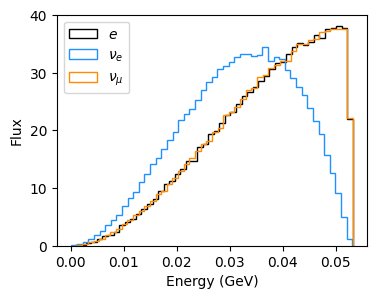

In [10]:
fig, ax = plt.subplots(figsize=(4,3))
num_bins = 50
_ = ax.hist(df['P_decay_e','0'], weights=df['w_flux'], bins=num_bins, density=True, histtype='step', lw=1, color='black', label=r'$e$')
_ = ax.hist(df['P_decay_nu_e','0'], weights=df['w_flux'], bins=num_bins, density=True, histtype='step', lw=1, color='dodgerblue', label=r'$\nu_e$')
_ = ax.hist(df['P_decay_nu_mu','0'], weights=df['w_flux'], bins=num_bins, density=True, histtype='step', lw=1, color='darkorange', label=r'$\nu_\mu$')

ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Flux')
ax.legend()
fig.savefig('plots/flux_histogram.png', dpi=300, bbox_inches='tight')


## Test 2

Now let's repeat it with a real muon beam

In [5]:
mudecay_beam = nuflux.fluxMC.MuonDecay()

df = mudecay_beam.simulate_decays(
                            pmin = 0,
                            pmax = 10,
                            beam_p0 = 3.8,
                            beam_dpop = 0.1,
                            Rpm=0.5,
                            NINT=10,
                            NINT_warmup=10,
                            NEVAL=1e5,
                            NEVAL_warmup=1e4,
                            )
_ = mudecay_beam.propagate_to_detector(
                            ZBEAMEND=250e2, # cm
                            ZBEAMEXIT=0, # cm
                            R_ND=[0,0,250e2+50e2], # cm
                            )
_ = mudecay_beam.flux_in_detector()

Detector acceptance: 0.3754020786006745  for nue, and 0.37435535820009547 for numu.


NameError: name 'fsize' is not defined

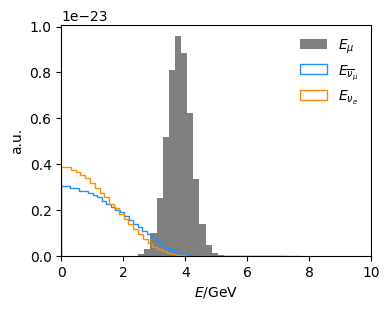

In [6]:
fig, ax = plt.subplots(figsize=(4,3))

n_bins = 50
ax.hist(mudecay_beam.Emu, weights=mudecay_beam.w, bins=n_bins, label=r'$E_\mu$',color='grey', histtype='stepfilled')
ax.hist(mudecay_beam.Enumu, weights=mudecay_beam.w, bins=n_bins, label=r'$E_{\overline{\nu}_\mu}$',color='dodgerblue', histtype='step')
ax.hist(mudecay_beam.Enue, weights=mudecay_beam.w, bins=n_bins, label=r'$E_{\nu_e}$',color='darkorange', histtype='step')

plt.legend(frameon=False,loc='upper right')
ax.set_xlim(0,10)
ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$E/$GeV')
ax.set_title(r'all decays',fontsize=fsize)

fig.savefig('plots/true_flux.png', dpi=300, bbox_inches='tight')

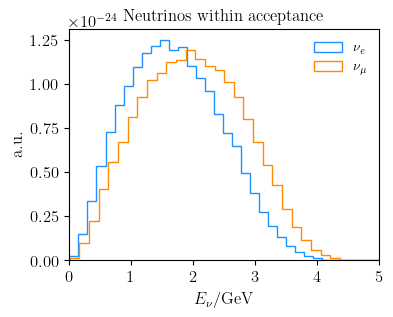

In [200]:
fig, ax = plt.subplots(figsize=(4,3))

n_bins = 50
ax.hist(mudecay_beam.Enue[mudecay_beam.mask_nue], weights=mudecay_beam.w[mudecay_beam.mask_nue], bins=n_bins, label=r'$\nu_e$',color='dodgerblue', histtype='step')
ax.hist(mudecay_beam.Enumu[mudecay_beam.mask_numu], weights=mudecay_beam.w[mudecay_beam.mask_numu], bins=n_bins, label=r'$\nu_\mu$',color='darkorange', histtype='step')

ax.legend(frameon=False,loc='upper right')
ax.set_xlim(0,5)
ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$E_{\nu}/$GeV')

ax.set_title(r'Neutrinos within acceptance',fontsize=fsize)

fig.savefig('plots/nu_fluxes.png', dpi=300, bbox_inches='tight')

## get nu CC xsecs used in GLOBES

In [201]:
from scipy import interpolate

log10E,sigmae,sigmamu,_,sigmaebar,sigmamubar,_ = np.genfromtxt('xsecs/XCC.dat',unpack=True)
exs = 10**(log10E)
sigmanue = interpolate.interp1d(exs,sigmae*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanuebar = interpolate.interp1d(exs,sigmaebar*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanumu = interpolate.interp1d(exs,sigmamu*exs*1e-38,bounds_error=False,fill_value=0.0)
sigmanumubar = interpolate.interp1d(exs,sigmamubar*exs*1e-38,bounds_error=False,fill_value=0.0)

## Number of events

In [202]:
Detmass = 1e6 # g
Ntargets=dn.const.NAvo*Detmass
nevents_nue=mudecay_beam.flux_nue_ND*sigmanue(mudecay_beam.Enue_ND)*Ntargets/(mudecay_beam.Enue_ND[1]-mudecay_beam.Enue_ND[0])
nevents_numu=mudecay_beam.flux_numu_ND*sigmanumubar(mudecay_beam.Enumu_ND)*Ntargets/(mudecay_beam.Enumu_ND[1]-mudecay_beam.Enumu_ND[0])

In [203]:
# Event rate
Ntot_nue = np.sum(nevents_nue)
Ntot_numu = np.sum(nevents_numu)

print(Ntot_nue)
print(Ntot_numu)

6310757.390735747
2902466.266546023


# Fluxes

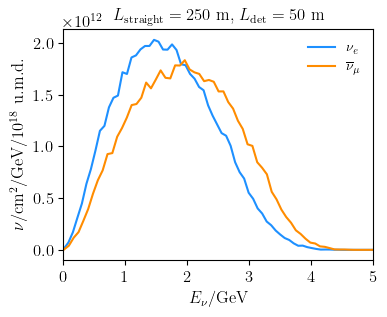

In [206]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(mudecay_beam.Enue_ND,mudecay_beam.flux_nue_ND,label=r'$\nu_e$',color='dodgerblue')
ax.plot(mudecay_beam.Enumu_ND,mudecay_beam.flux_numu_ND,label=r'$\overline{\nu}_\mu$',color='darkorange')

ax.legend(frameon=False,loc='upper right')
ax.set_xlim(0,5)
ax.set_ylabel(r'$\nu$/cm$^2$/GeV/$10^{18}$ u.m.d.')
ax.set_xlabel(r'$E_{\nu}/$GeV')

ax.set_title(r'$L_{\rm straight} = 250$~m, $L_{\rm det} = 50$~m ',fontsize=fsize)
# ax.set_yscale('log'),
# ax.set_ylim(1e9,1e12)
fig.savefig('plots/nu_fluxes_smooth.png', dpi=300, bbox_inches='tight')

# N events

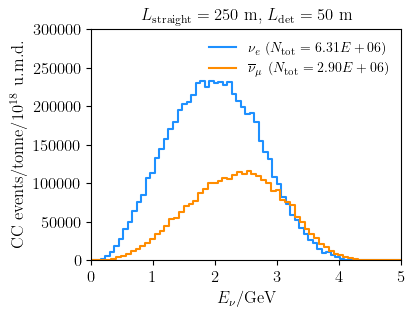

In [207]:
fig, ax = plt.subplots(figsize=(4,3))

ax.step(mudecay_beam.Enue_ND,nevents_nue,label=fr'$\nu_e$ ($N_{{\rm tot}} = {Ntot_nue:.2E}$)',color='dodgerblue')
ax.step(mudecay_beam.Enumu_ND,nevents_numu,label=fr'$\overline{{\nu}}_\mu$ ($N_{{\rm tot}} = {Ntot_numu:.2E}$)',color='darkorange')


ax.legend(frameon=False,loc='upper right')
ax.set_xlim(0,5)
ax.set_ylim(0,3e5)
ax.set_ylabel(r'CC events/tonne/$10^{18}$ u.m.d.')
ax.set_xlabel(r'$E_{\nu}/$GeV')

ax.set_title(r'$L_{\rm straight} = 250$~m, $L_{\rm det} = 50$~m ',fontsize=fsize)

fig.savefig('plots/nu_events.png', dpi=300, bbox_inches='tight')